# 1) ```Problema de negócio```

É recorrente no nosso país o uso da máquina pública para execução de obras desecessárias, que não cumprem com seus objetivos e muitas nem mesmo são finalizadas, correspondendo assim a um enorme disperdício de dinheiro do orçamento público que poderia ser melhor empregado.
Um dos principais pontos onde isso se observa, quer seja pelo grande volume de verba orçamentária e dos fundos soberados, quer seja pela grande demanda de obras em virtude da capilaridade de sua atuação é a área de Educação.
Esse problema se agrava por parecer ser algo invisível, que passa despercebido pelo radar da sociedade e só é notado pelos órgãos controladores, quando muito, posteriormente, com as obras já em execução e grande volume de dinheiro já derperdiçado.

# Questonamentos levantados em razão do problema de negócio

### Seria possível encontrar padrões que nos permitam identificar, antes do inicio da execução da obra, a possibilidade dessa obra vir a não ser concluida?

### Seria possível construir com base em dados um modelo de classificação capaz de, com base em parâmetros tecnicos definidos, classificar a qualidade de investimentos em educação das Obras objeto de convênios já firmados até hoje com o FNDE e, com base nessa classificação, já realizar uma classificação de novas obras requeridas, no momento desse requerimento?

# 2) ```Aquisição dos dados```

## 2.1) Principal:
### Obras - DataSet: Arquivo csv publicado mensalmente no portal do SIMEC contendo todas as obras autorizadas cujo financiamento é oriundo do FNDE desde de sua criação até a presente data.

## 2.2) Secundários:
### Dados populacionais dos municípios - Dataset: IBGE cidades

### Dados com quantide de alunos, vagas e escolas por município - Dataset: Dataset: Arquivo csv microdados_sensoescolar


### Dados complementares das empresas vencedoras dos processos licitatórios - Dataset: Api Receita Federal ou arquivo csv

## 2.1. Importação dos dados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

In [ ]:
#Monta o drive caso estaja rodando no colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    print('Não está rodando no Colab')

Mounted at /content/drive


In [ ]:
#Configuração dos caminhos e arquivos
dir_data = '/content/drive/My Drive/DH PI Contratos Públicos/PI/data/'
arquivo_simec = 'SIMEC_transparenciadeobras_12-07-2022_022452_V3.csv'
arquivo_municipio = 'Dados_SOCIODEMOGRAFICOS.csv'
arquivo_cnpj = 'cnpj.csv'

## Nesse DataFrame temos as seguintes informações:
- a situação da obra (concluida, em andamento, inacabada)
- o município onde a obra se localiza. É o município que firmou o convênio com o Governo Federal
- o local exato da obra
- o termo do convênio que foi firmado e o VALOR dele, ou seja, valor da obra
- o tipo de escola (são alguns tipos padronizados, com isso conseguimos saber se havia a necessidade daquela obra com base na demanda;
- que tipo de obra é, se contrução, reforma ou ampliação;
- a empresa contratada
- se a obra está inacabada por abandono da empresa contratada
- a quanto tempo a obra foi abandonada e o valor que foi gasto nela
- ........dentre outras

# O que buscamos dos outros datasets para complementar nossa tese:
- se a população daquele município, por idade, corresponde a uma demanda real por aquele tipo exato de obra, hoje ou em um futuro próximo;
- se o numero de escolas e vagas daquele municipio ja atendem a demanda ou mesmo são sub-utilizadas
- qual o estado de funcionamento dessas escolas existentes
- qual a previsão de crescimento da população daquele municipio, por idade
- qual a situação atual da empresa contratada se ativa ou não
- quais os sócios das empresas contratadas
- se na data da assinatura do convênio havia vinculo partidário entre os prefeitos e o governo federal

# O que pretendemos usar:
- algoritmo de classificação pois teremos varias variáveis categoricas tanto 0/1 quanto ordinais, capaz de classificar os investimentos já realizados em necessários e eficientes, necessarios mas ineficientes, desnecessários, suspeitos e ineficientes (essa classidicação é só um esboço e pode pode mudar). 
- Com base nas informações acima queremos criar um algoritmo que preveja com base nas obras abandonadas, atrazadas e alguns outros critecios, a possibilidade de uma obra não vir a ser concluida antes mesmo de iniciada.
- com base na classificação acima e no algoritmo queremos criar um modelo de classificação que automaticamente classifique novas obras assim que cadastradas.

### Carregando o dataset principal

In [ ]:
# import csv V3
#df = pd.read_csv(dir_data + arquivo_simec, sep=';', encoding='ISO-8859-1')

In [ ]:
# import excel V4 consolidado com dados dos municípios
df = pd.read_excel('/content/drive/MyDrive/DH/DH PI Contratos Públicos/PI/data/SIMEC_transparenciadeobras_12-07-2022_022452_V4.xlsx')

FileNotFoundError: ignored

In [ ]:
# import excel V4 consolidado com dados dos municípios
df = pd.read_excel('/content/drive/MyDrive/DH PI Contratos Públicos/PI/data/SIMEC_transparenciadeobras_12-07-2022_022452_V4.xlsx')

In [ ]:
df.nunique()

ID                                                        29975
Nome                                                      26067
Situação                                                      9
Município                                                  4838
UF                                                           27
                                                          ...  
Escolarização 6 a 14 anos - % [2010]                        168
IDHM Índice de desenvolvimento humano municipaL [2010]      347
Receitas realizadas - R$ (×1000) [2017]                    4944
Despesas empenhadas - R$ (×1000) [2017]                    4943
PIB per capita - R$ [2019]                                 4946
Length: 68, dtype: int64

In [ ]:
# Alterando para numérico, para corrigir colunas importadas com mais de um type
df.Cod_mun = pd.to_numeric(df.Cod_mun , errors='coerce')

### Carregando os datasets secundários

In [ ]:
# Carregando DataFrame com as informações dos CNPJs
#empresa_cnpj = pd.read_csv(dir_data + arquivo_cnpj, sep=',', dtype={'cnpj':'str'}, parse_dates=['abertura'])
#empresa_cnpj = pd.read_csv('/content/drive/MyDrive/DH/DH PI Contratos Públicos/PI/data/cnpj.csv', sep=',', dtype={'cnpj':'str'}, parse_dates=['abertura'])
empresa_cnpj = pd.read_csv('/content/drive/MyDrive/DH PI Contratos Públicos/PI/data/cnpj.csv', sep=',', dtype={'cnpj':'str'}, parse_dates=['abertura'])

# empresa_cnpj['abertura'] = empresa_cnpj['abertura'].dt.strftime('%m/%d/%Y')
empresa_cnpj.info()
empresa_cnpj.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8746 entries, 0 to 8745
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   cnpj                      8746 non-null   object        
 1   nome                      8746 non-null   object        
 2   abertura                  8746 non-null   datetime64[ns]
 3   porte                     8746 non-null   object        
 4   natureza_juridica         8746 non-null   object        
 5   uf                        8739 non-null   object        
 6   capital_social            8746 non-null   float64       
 7   atividade_principal       8746 non-null   object        
 8   atividade_principal_code  8746 non-null   object        
 9   ultima_atualizacao        8746 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 683.4+ KB


,cnpj,nome,abertura,porte,natureza_juridica,uf,capital_social,atividade_principal,atividade_principal_code,ultima_atualizacao
0,10298629000113,JULIO MARIO DA SILVA LTDA,2008-08-25,EMPRESA DE PEQUENO PORTE,206-2 - Sociedade Empresária Limitada,PE,900000.0,Locação de automóveis sem condutor,77.11-0-00,2022-06-16
1,41862466000183,MR MULT LTDA,2021-07-05,MICRO EMPRESA,206-2 - Sociedade Empresária Limitada,GO,40000.0,Instalação e manutenção elétrica,43.21-5-00,2022-07-26


In [ ]:
# Acessando o Dataframe Principal

df.head(10)

,ID,Nome,Situação,Município,UF,Mun_UF,Cod_mun,CEP,Logradouro,Bairro,...,Saldo CDB,Saldo TOTAL,Área Territorial - km² [2021],População estimada - pessoas [2021],Densidade demográfica - hab/km² [2010],Escolarização 6 a 14 anos - % [2010],IDHM Índice de desenvolvimento humano municipaL [2010],Receitas realizadas - R$ (×1000) [2017],Despesas empenhadas - R$ (×1000) [2017],PIB per capita - R$ [2019]
0,1365,830167 - Escola de Educação Infantil - Tipo B ...,Concluída,Tauá,CE,Tauá-CE,23133020.0,636600000.0,Rua PEDRO INÁCIO DE SOUSA,BEZERRA E SOUSA,...,0.0,0.0,4010618.0,592590.0,1387.0,97.7,0.633,1.360281e+10,1.357133e+10,1124542.0
1,1366,830361 - Escola de Educação Infantil - Tipo B ...,Concluída,Conchas,SP,Conchas-SP,35123080.0,185700000.0,RUA LUIZ SARTORI,JARDIM OLIVEIRA,...,0.0,10757607.0,46612.0,181380.0,3495.0,97.6,0.736,5.472410e+09,5.064559e+09,2128028.0
2,1367,830053 - Escola de Educação Infantil - Itararé/SP,Concluída,Itararé,SP,Itararé-SP,35232060.0,184600000.0,Rua Sofia Dias Menck,Jd. Santa terezinha,...,0.0,789377.0,100386.0,507780.0,4776.0,9.8,0.703,1.133217e+09,1.002704e+10,1870948.0
3,1368,710101 - Escola de Educação Infantil - Reserva...,Concluída,Reserva do Cabaçal,MT,Reserva do Cabaçal-MT,51071560.0,782650000.0,Rua princesa izabel,Centro,...,0.0,0.0,1331677.0,27540.0,192.0,99.2,0.676,1.438297e+09,1.233900e+09,1408676.0
4,1370,700022 - Escola de Educação Inf - São João do ...,Inacabada,São João do Jaguaribe,CE,São João do Jaguaribe-CE,23125020.0,629650000.0,Rua Daniel Rodrigues,Centro,...,0.0,0.0,279451.0,75570.0,2817.0,99.2,0.654,2.131131e+09,1.866154e+09,1238996.0
5,1371,830057 - Escola de Educação Infantil - Senador...,Concluída,Senador Sá,CE,Senador Sá-CE,23128090.0,624700000.0,Rua Nossa Senhora do Carmo,Centro,...,0.0,0.0,424642.0,77580.0,1616.0,98.2,0.603,1.644474e+08,2.179174e+09,684158.0
6,1372,700064 - Escola de Educação Infantil - Tipo B ...,Concluída,Tamboril,CE,Tamboril-CE,23132030.0,637500000.0,Rua Coronel Salustiano,Centro,...,0.0,4669721.0,2014543.0,261990.0,1298.0,97.1,0.058,7.320589e+09,6.810523e+09,913965.0
7,1373,830106 - Escola de Educação Infantil - Florian...,Concluída,Floriano,PI,Floriano-PI,22039090.0,648000000.0,Rua José Soares,Irapuá,...,0.0,0.0,3407979.0,601110.0,1692.0,98.1,0.007,1.416413e+10,1.209285e+10,200134.0
8,1374,700012 - Escola Educação Inf - B Vila Nova - S...,Obra Cancelada,São Luís,MA,São Luís-MA,21113000.0,650304700.0,Rua Nossa Senhora das Graças,Bairro Vila Nova,...,0.0,0.0,583063.0,11159320.0,121569.0,96.8,0.768,2.818009e+11,2.532501e+10,2913532.0
9,1375,700027/2008 - Escola de Educação Infantil - It...,Concluída,Itaituba,PA,Itaituba-PA,15036060.0,681800100.0,Rodovia Transamazônica,Comércio,...,0.0,0.0,62042472.0,1015410.0,157.0,94.4,0.064,2.247731e+10,2.288822e+10,2021409.0


## 2.2. Análise inicial dos dados

In [ ]:
df['ID'].duplicated().sum()

0

### Preparando a base

In [ ]:
df.columns

Index(['ID', 'Nome', 'Situação', 'Município', 'UF', 'Mun_UF', 'Cod_mun', 'CEP',
       'Logradouro', 'Bairro', 'Termo/Convênio', 'Ano Convênio',
       'Fim da Vigência Termo/Convênio', 'Situação do Termo/Convênio',
       'Percentual de Execução', 'Data Prevista de Conclusão da Obra',
       'Tipo de ensino / Modalidade', 'Tipo do Projeto', 'Tipo da Obra',
       'Classificação da Obra', 'Valor Pactuado pelo FNDE',
       'Rede de Ensino Público', 'CNPJ', 'Inscrição Estadual',
       'Nome da Entidade', 'Razão Social', 'Email', 'Sigla',
       'Telefone Comercial', 'Fax', 'CEP Entidade', 'Logradouro Entidade',
       'Complemento Entidade', 'Número Entidade', 'Bairro Entidade',
       'UF Entidade', 'Munícipio Entidade', 'Modalidade de Licitação',
       'Número da Licitação', 'Homologação da Licitação', 'Empresa Contratada',
       'Data de Assinatura do Contrato', 'Prazo de Vigência',
       'Data de Término do Contrato', 'Valor do Contrato',
       'Valor Pactuado com o FNDE',
    

In [ ]:
pd.set_option('display.max_columns', 60)
df_projeto = df.filter(items=['ID',
                              'Nome',
                              'Situação',
                              'Município',
                              'UF',
                              'Mun_UF',
                              'Cod_mun',
                              'Termo/Convênio',
                              'Percentual de Execução',
                              'Data Prevista de Conclusão da Obra',
                              'Tipo de ensino / Modalidade',
                              'Tipo do Projeto',
                              'Tipo da Obra',
                              'Valor Pactuado pelo FNDE',
                              'Modalidade de Licitação',
                              'Homologação da Licitação',
                              'Empresa Contratada',
                              'Data de Assinatura do Contrato',
                              'Valor do Contrato',
                              'Valor Pactuado com o FNDE',
                              'Data da Última Vistoria do Estado ou Município',
                              'Situação da Vistoria',
                              'OBS',
                              'Total Pago',
                              'Área Territorial - km² [2021]',
                              'População estimada - pessoas [2021]',
                              'Densidade demográfica - hab/km² [2010]',
                              'Escolarização 6 a 14 anos - % [2010]',
                              'IDHM Índice de desenvolvimento humano municipaL [2010]',
                              'Receitas realizadas - R$ (×1000) [2017]',
                              'Despesas empenhadas - R$ (×1000) [2017]',
                              'PIB per capita - R$ [2019]'])

In [ ]:
#Ajustando o campo CPNJ para separar o nome da empresa e o cnpj em features separadas
df_projeto['cnpj_empresa_contratada'] = df_projeto['Empresa Contratada'].str.extract(r'(\([0-9]{14}\))', expand=False).str[1:-1]
df_projeto['nom_empresa_contratada'] = df_projeto['Empresa Contratada'].str.slice(17)
df_projeto.drop(columns=['Empresa Contratada'], inplace=True)

df_projeto.head(2)

,ID,Nome,Situação,Município,UF,Mun_UF,Cod_mun,Termo/Convênio,Percentual de Execução,Data Prevista de Conclusão da Obra,Tipo de ensino / Modalidade,Tipo do Projeto,Tipo da Obra,Valor Pactuado pelo FNDE,Modalidade de Licitação,Homologação da Licitação,Data de Assinatura do Contrato,Valor do Contrato,Valor Pactuado com o FNDE,Data da Última Vistoria do Estado ou Município,Situação da Vistoria,OBS,Total Pago,Área Territorial - km² [2021],População estimada - pessoas [2021],Densidade demográfica - hab/km² [2010],Escolarização 6 a 14 anos - % [2010],IDHM Índice de desenvolvimento humano municipaL [2010],Receitas realizadas - R$ (×1000) [2017],Despesas empenhadas - R$ (×1000) [2017],PIB per capita - R$ [2019],cnpj_empresa_contratada,nom_empresa_contratada
0,1365,830167 - Escola de Educação Infantil - Tipo B ...,Concluída,Tauá,CE,Tauá-CE,23133020.0,830167/2007,100.0,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,9500000.0,Tomada de Preço,2008-07-04 00:00:00,2008-07-04,100377602.0,9500000.0,2012-09-24,Concluído,NaN,NaN,4010618.0,592590.0,1387.0,97.7,0.633,1.360281e+10,1.357133e+10,1124542.0,63476931000180,Edmil Eletrificação LTDA
1,1366,830361 - Escola de Educação Infantil - Tipo B ...,Concluída,Conchas,SP,Conchas-SP,35123080.0,830361/2007,100.0,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,111707809.0,Tomada de Preço,2009-01-12 00:00:00,2009-04-02,111707809.0,111707809.0,2011-12-30,Concluído,NaN,NaN,46612.0,181380.0,3495.0,97.6,0.736,5.472410e+09,5.064559e+09,2128028.0,61600094000124,KITA CONSTRUTORA LTDA


Criando o sumario de obras

In [ ]:
def cria_sumario(agrupador):
    """Cria um sumario com os campos:
    """
    sumario = []

    sumario.append(df_projeto.groupby(agrupador)['Situação da Vistoria'].count().reset_index().rename(columns={'Situação da Vistoria': 'num_obras'}))
    sumario.append(df_projeto[df_projeto['Situação da Vistoria'] == 'Concluído'].groupby(agrupador)['Situação da Vistoria'].count().reset_index().rename(columns={'Situação da Vistoria': 'num_concluidas'}))
    sumario.append(df_projeto[df_projeto['Situação da Vistoria'] == 'Em Execução'].groupby(agrupador)['Situação da Vistoria'].count().reset_index().rename(columns={'Situação da Vistoria': 'num_em_execucao'}))
    sumario.append(df_projeto[(df_projeto['Situação da Vistoria'] != 'Em Execução') & (df_projeto['Situação da Vistoria'] != 'Concluído')].groupby(agrupador)['Situação da Vistoria'].count().reset_index().rename(columns={'Situação da Vistoria': 'num_nao_concluidas'}))

    df_final = sumario[0]
    for s in sumario[1:]:
        df_final = pd.merge(df_final,s, on=agrupador, how='left')

    df_final['%concluidas'] = np.around((df_final['num_concluidas']/df_final['num_obras'])*100,2)
    df_final['%nao_concluidas'] = np.around((df_final['num_nao_concluidas']/df_final['num_obras'])*100,2)

    df_final.fillna(0, inplace=True)

    return df_final

In [ ]:
sumario_municipio = cria_sumario('Cod_mun')
sumario_municipio.head(2)


,Cod_mun,num_obras,num_concluidas,num_em_execucao,num_nao_concluidas,%concluidas,%nao_concluidas
0,11000150.0,7,5.0,2.0,0.0,71.43,0.0
1,11000230.0,7,7.0,0.0,0.0,100.00,0.0


In [ ]:
sumario_empresa = cria_sumario('cnpj_empresa_contratada')
sumario_empresa.head(2)

,cnpj_empresa_contratada,num_obras,num_concluidas,num_em_execucao,num_nao_concluidas,%concluidas,%nao_concluidas
0,00000000000000,15,12.0,1.0,2.0,80.0,13.33
1,00012724000155,1,1.0,0.0,0.0,100.0,0.00


In [ ]:
sumario_empresa.describe()

,num_obras,num_concluidas,num_em_execucao,num_nao_concluidas,%concluidas,%nao_concluidas
count,8718.000000,8718.000000,8718.000000,8718.000000,8718.000000,8718.000000
mean,2.546111,1.788369,0.502868,0.254875,64.919320,10.469396
std,3.563305,3.062249,1.030866,0.857901,43.396557,27.279626
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,100.000000,0.000000
75%,3.000000,2.000000,1.000000,0.000000,100.000000,0.000000
max,86.000000,76.000000,16.000000,36.000000,100.000000,100.000000


Consolida os datasets de apoio ao sumario correspondente e adiciona prefixos as features para facilitar a identificação quando juntar com o dataser principal(df_projeto)

In [ ]:
empresa_cnpj = pd.merge(empresa_cnpj, sumario_empresa, left_on='cnpj', right_on='cnpj_empresa_contratada',  how='left')
empresa_cnpj.drop(columns='cnpj_empresa_contratada', inplace=True)
empresa_cnpj.rename(lambda x: 'emp_' + x,axis=1, inplace=True) # adiciona prefixo no nome para facilitar a identificaçaõ quando consolidar com o dataset principal(df_projeto)
empresa_cnpj.head(2)

,emp_cnpj,emp_nome,emp_abertura,emp_porte,emp_natureza_juridica,emp_uf,emp_capital_social,emp_atividade_principal,emp_atividade_principal_code,emp_ultima_atualizacao,emp_num_obras,emp_num_concluidas,emp_num_em_execucao,emp_num_nao_concluidas,emp_%concluidas,emp_%nao_concluidas
0,10298629000113,JULIO MARIO DA SILVA LTDA,2008-08-25,EMPRESA DE PEQUENO PORTE,206-2 - Sociedade Empresária Limitada,PE,900000.0,Locação de automóveis sem condutor,77.11-0-00,2022-06-16,16.0,12.0,3.0,1.0,75.0,6.25
1,41862466000183,MR MULT LTDA,2021-07-05,MICRO EMPRESA,206-2 - Sociedade Empresária Limitada,GO,40000.0,Instalação e manutenção elétrica,43.21-5-00,2022-07-26,1.0,1.0,0.0,0.0,100.0,0.00


In [ ]:
# merge dados municípios - não será necessário

#munic = pd.merge(munic, sumario_municipio, left_on='Código', right_on='Cod_mun',  how='left')
#munic.drop(columns='Código', inplace=True)
#munic.rename(lambda x: 'mun_' + x,axis=1, inplace=True) # adiciona prefixo no nome para facilitar a identificaçaõ quando consolidar com o dataset principal(df_projeto)
#munic.head(2)

Adicionando a um novo dataser principal as informações de apoio e removendo features duplicadas

In [ ]:
# criando df_projeto_manipulada com merge com dados munic - não será necessário
df_projeto_manipulada = pd.merge(df_projeto, munic,left_on='Cod_mun', right_on='mun_Cod_mun', how='left')
df_projeto_manipulada.head(2)

NameError: ignored

In [ ]:
# merge df_projeto com empresa_cnpj

#df_projeto_manipulada = pd.merge(df_projeto_manipulada, empresa_cnpj,left_on='cnpj_empresa_contratada', right_on='emp_cnpj', how='left')
df_projeto_manipulada = pd.merge(df_projeto, empresa_cnpj,left_on='cnpj_empresa_contratada', right_on='emp_cnpj', how='left')
df_projeto_manipulada.head(2)

,ID,Nome,Situação,Município,UF,Mun_UF,Cod_mun,Termo/Convênio,Percentual de Execução,Data Prevista de Conclusão da Obra,Tipo de ensino / Modalidade,Tipo do Projeto,Tipo da Obra,Valor Pactuado pelo FNDE,Modalidade de Licitação,Homologação da Licitação,Data de Assinatura do Contrato,Valor do Contrato,Valor Pactuado com o FNDE,Data da Última Vistoria do Estado ou Município,Situação da Vistoria,OBS,Total Pago,Área Territorial - km² [2021],População estimada - pessoas [2021],Densidade demográfica - hab/km² [2010],Escolarização 6 a 14 anos - % [2010],IDHM Índice de desenvolvimento humano municipaL [2010],Receitas realizadas - R$ (×1000) [2017],Despesas empenhadas - R$ (×1000) [2017],PIB per capita - R$ [2019],cnpj_empresa_contratada,nom_empresa_contratada,emp_cnpj,emp_nome,emp_abertura,emp_porte,emp_natureza_juridica,emp_uf,emp_capital_social,emp_atividade_principal,emp_atividade_principal_code,emp_ultima_atualizacao,emp_num_obras,emp_num_concluidas,emp_num_em_execucao,emp_num_nao_concluidas,emp_%concluidas,emp_%nao_concluidas
0,1365,830167 - Escola de Educação Infantil - Tipo B ...,Concluída,Tauá,CE,Tauá-CE,23133020.0,830167/2007,100.0,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,9500000.0,Tomada de Preço,2008-07-04 00:00:00,2008-07-04,100377602.0,9500000.0,2012-09-24,Concluído,NaN,NaN,4010618.0,592590.0,1387.0,97.7,0.633,1.360281e+10,1.357133e+10,1124542.0,63476931000180,Edmil Eletrificação LTDA,63476931000180,J L H VIEIRA CONSTRUCOES - EIRELI,1991-05-06,DEMAIS,230-5 - Empresa Individual de Responsabilidade...,CE,521789.0,Construção de estações e redes de distribuição...,42.21-9-02,2022-07-23,1.0,1.0,0.0,0.0,100.00,0.0
1,1366,830361 - Escola de Educação Infantil - Tipo B ...,Concluída,Conchas,SP,Conchas-SP,35123080.0,830361/2007,100.0,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,111707809.0,Tomada de Preço,2009-01-12 00:00:00,2009-04-02,111707809.0,111707809.0,2011-12-30,Concluído,NaN,NaN,46612.0,181380.0,3495.0,97.6,0.736,5.472410e+09,5.064559e+09,2128028.0,61600094000124,KITA CONSTRUTORA LTDA,61600094000124,KITA CONSTRUTORA LTDA,1989-11-27,EMPRESA DE PEQUENO PORTE,206-2 - Sociedade Empresária Limitada,SP,350000.0,Construção de edifícios,41.20-4-00,2022-06-27,6.0,4.0,2.0,0.0,66.67,0.0


In [ ]:
#Verifica se todas as empresas possui informação na base de apoio
print('Quantidade de cnpj faltante: '
        ,df_projeto_manipulada[~df_projeto_manipulada['cnpj_empresa_contratada'].isnull() & df_projeto_manipulada['cnpj_empresa_contratada'].isnull()]['cnpj_empresa_contratada'].count())

Quantidade de cnpj faltante:  0


### Pendente:
* Criar a idade da empresa
* Criar um flag se a empresa é fora da uf da obra
* Analisar inconsistencias na base de cnpj (usar o outro projeto)

In [ ]:
df_projeto_manipulada.columns

Index(['ID', 'Nome', 'Situação', 'Município', 'UF', 'Mun_UF', 'Cod_mun',
       'Termo/Convênio', 'Percentual de Execução',
       'Data Prevista de Conclusão da Obra', 'Tipo de ensino / Modalidade',
       'Tipo do Projeto', 'Tipo da Obra', 'Valor Pactuado pelo FNDE',
       'Modalidade de Licitação', 'Homologação da Licitação',
       'Data de Assinatura do Contrato', 'Valor do Contrato',
       'Valor Pactuado com o FNDE',
       'Data da Última Vistoria do Estado ou Município',
       'Situação da Vistoria', 'OBS', 'Total Pago',
       'Área Territorial - km² [2021]', 'População estimada - pessoas [2021]',
       'Densidade demográfica - hab/km² [2010]',
       'Escolarização 6 a 14 anos - % [2010]',
       'IDHM Índice de desenvolvimento humano municipaL [2010]',
       'Receitas realizadas - R$ (×1000) [2017]',
       'Despesas empenhadas - R$ (×1000) [2017]', 'PIB per capita - R$ [2019]',
       'cnpj_empresa_contratada', 'nom_empresa_contratada', 'emp_cnpj',
       'emp_nome', 

In [ ]:
df_projeto_manipulada.drop(['Município','UF', 'Mun_UF'], axis=1, inplace=True)

In [ ]:
df_projeto_manipulada

,ID,Nome,Situação,Cod_mun,Termo/Convênio,Percentual de Execução,Data Prevista de Conclusão da Obra,Tipo de ensino / Modalidade,Tipo do Projeto,Tipo da Obra,Valor Pactuado pelo FNDE,Modalidade de Licitação,Homologação da Licitação,Data de Assinatura do Contrato,Valor do Contrato,Valor Pactuado com o FNDE,Data da Última Vistoria do Estado ou Município,Situação da Vistoria,OBS,Total Pago,Área Territorial - km² [2021],População estimada - pessoas [2021],Densidade demográfica - hab/km² [2010],Escolarização 6 a 14 anos - % [2010],IDHM Índice de desenvolvimento humano municipaL [2010],Receitas realizadas - R$ (×1000) [2017],Despesas empenhadas - R$ (×1000) [2017],PIB per capita - R$ [2019],cnpj_empresa_contratada,nom_empresa_contratada,emp_cnpj,emp_nome,emp_abertura,emp_porte,emp_natureza_juridica,emp_uf,emp_capital_social,emp_atividade_principal,emp_atividade_principal_code,emp_ultima_atualizacao,emp_num_obras,emp_num_concluidas,emp_num_em_execucao,emp_num_nao_concluidas,emp_%concluidas,emp_%nao_concluidas
0,1365,830167 - Escola de Educação Infantil - Tipo B ...,Concluída,23133020.0,830167/2007,100.00,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,9500000.0,Tomada de Preço,2008-07-04 00:00:00,2008-07-04,100377602.0,9500000.0,2012-09-24,Concluído,NaN,NaN,4010618.0,592590.0,1387.0,97.7,0.633,1.360281e+10,1.357133e+10,1124542.0,63476931000180,Edmil Eletrificação LTDA,63476931000180,J L H VIEIRA CONSTRUCOES - EIRELI,1991-05-06,DEMAIS,230-5 - Empresa Individual de Responsabilidade...,CE,521789.0,Construção de estações e redes de distribuição...,42.21-9-02,2022-07-23,1.0,1.0,0.0,0.0,100.00,0.0
1,1366,830361 - Escola de Educação Infantil - Tipo B ...,Concluída,35123080.0,830361/2007,100.00,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,111707809.0,Tomada de Preço,2009-01-12 00:00:00,2009-04-02,111707809.0,111707809.0,2011-12-30,Concluído,NaN,NaN,46612.0,181380.0,3495.0,97.6,0.736,5.472410e+09,5.064559e+09,2128028.0,61600094000124,KITA CONSTRUTORA LTDA,61600094000124,KITA CONSTRUTORA LTDA,1989-11-27,EMPRESA DE PEQUENO PORTE,206-2 - Sociedade Empresária Limitada,SP,350000.0,Construção de edifícios,41.20-4-00,2022-06-27,6.0,4.0,2.0,0.0,66.67,0.0
2,1367,830053 - Escola de Educação Infantil - Itararé/SP,Concluída,35232060.0,830053/2007,100.00,2014-08-22,Educação Básica,Escola de Educação Infantil Tipo B,Construção,10240310.0,Convite,2008-12-04 00:00:00,2008-12-04,102171213.0,10240310.0,2014-08-18,Concluído,NaN,NaN,100386.0,507780.0,4776.0,9.8,0.703,1.133217e+09,1.002704e+10,1870948.0,07336385000101,R. G. CONSTRUCOES ITAPEVA LTDA,07336385000101,R. G. CONSTRUCOES ITAPEVA LTDA,2005-05-04,MICRO EMPRESA,206-2 - Sociedade Empresária Limitada,SP,0.0,********,00.00-0-00,2022-07-04,3.0,3.0,0.0,0.0,100.00,0.0
3,1368,710101 - Escola de Educação Infantil - Reserva...,Concluída,51071560.0,710101/2008,63.88,2014-01-02,Educação Básica,Escola de Educação Infantil Tipo B,Construção,95038237.0,Tomada de Preço,2012-05-16 00:00:00,2008-12-05,9473581.0,95038237.0,2014-07-22,Paralisado,Contrato Rescindido,NaN,1331677.0,27540.0,192.0,99.2,0.676,1.438297e+09,1.233900e+09,1408676.0,09101297000156,BURITIS COMERCIO E CONSTRUCOES LTDA,09101297000156,BURITIS COMERCIO E CONSTRUCOES LTDA,2007-03-10,MICRO EMPRESA,206-2 - Sociedade Empresária Limitada,MT,0.0,********,00.00-0-00,2022-06-15,1.0,0.0,0.0,1.0,0.00,100.0
4,1370,700022 - Escola de Educação Inf - São João do ...,Inacabada,23125020.0,700022/2008,36.97,2014-11-25,Educação Básica,Escola de Educação Infantil Tipo B,Construção,12000780.0,Tomada de Preço,2011-06-22 00:00:00,2011-06-22,11989140.0,12000780.0,2015-03-17,Paralisado,Abandono da empresa,NaN,279451.0,75570.0,2817.0,99.2,0.654,2.131131e+09,1.866154e+09,1238996.0,00139895000140,CONSTRUTORA AURORENSE LTDA,00139895000140,CONSTRUTORA AURORENSE LTDA,1994-10-08,MICRO EMPRESA,206-2 - Sociedade Empresária Limitada,CE,0.0,********,00.00-0-00,2022-06-08,1.0,0.0,0.0,1.0,0.00,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
df_projeto_manipulada

,ID,Nome,Situação,Cod_mun,Termo/Convênio,Percentual de Execução,Data Prevista de Conclusão da Obra,Tipo de ensino / Modalidade,Tipo do Projeto,Tipo da Obra,Valor Pactuado pelo FNDE,Modalidade de Licitação,Homologação da Licitação,Data de Assinatura do Contrato,Valor do Contrato,Valor Pactuado com o FNDE,Data da Última Vistoria do Estado ou Município,Situação da Vistoria,OBS,Total Pago,Área Territorial - km² [2021],População estimada - pessoas [2021],Densidade demográfica - hab/km² [2010],Escolarização 6 a 14 anos - % [2010],IDHM Índice de desenvolvimento humano municipaL [2010],Receitas realizadas - R$ (×1000) [2017],Despesas empenhadas - R$ (×1000) [2017],PIB per capita - R$ [2019],cnpj_empresa_contratada,nom_empresa_contratada,emp_cnpj,emp_nome,emp_abertura,emp_porte,emp_natureza_juridica,emp_uf,emp_capital_social,emp_atividade_principal,emp_atividade_principal_code,emp_ultima_atualizacao,emp_num_obras,emp_num_concluidas,emp_num_em_execucao,emp_num_nao_concluidas,emp_%concluidas,emp_%nao_concluidas
0,1365,830167 - Escola de Educação Infantil - Tipo B ...,Concluída,23133020.0,830167/2007,100.00,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,9500000.0,Tomada de Preço,2008-07-04 00:00:00,2008-07-04,100377602.0,9500000.0,2012-09-24,Concluído,NaN,NaN,4010618.0,592590.0,1387.0,97.7,0.633,1.360281e+10,1.357133e+10,1124542.0,63476931000180,Edmil Eletrificação LTDA,63476931000180,J L H VIEIRA CONSTRUCOES - EIRELI,1991-05-06,DEMAIS,230-5 - Empresa Individual de Responsabilidade...,CE,521789.0,Construção de estações e redes de distribuição...,42.21-9-02,2022-07-23,1.0,1.0,0.0,0.0,100.00,0.0
1,1366,830361 - Escola de Educação Infantil - Tipo B ...,Concluída,35123080.0,830361/2007,100.00,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,111707809.0,Tomada de Preço,2009-01-12 00:00:00,2009-04-02,111707809.0,111707809.0,2011-12-30,Concluído,NaN,NaN,46612.0,181380.0,3495.0,97.6,0.736,5.472410e+09,5.064559e+09,2128028.0,61600094000124,KITA CONSTRUTORA LTDA,61600094000124,KITA CONSTRUTORA LTDA,1989-11-27,EMPRESA DE PEQUENO PORTE,206-2 - Sociedade Empresária Limitada,SP,350000.0,Construção de edifícios,41.20-4-00,2022-06-27,6.0,4.0,2.0,0.0,66.67,0.0
2,1367,830053 - Escola de Educação Infantil - Itararé/SP,Concluída,35232060.0,830053/2007,100.00,2014-08-22,Educação Básica,Escola de Educação Infantil Tipo B,Construção,10240310.0,Convite,2008-12-04 00:00:00,2008-12-04,102171213.0,10240310.0,2014-08-18,Concluído,NaN,NaN,100386.0,507780.0,4776.0,9.8,0.703,1.133217e+09,1.002704e+10,1870948.0,07336385000101,R. G. CONSTRUCOES ITAPEVA LTDA,07336385000101,R. G. CONSTRUCOES ITAPEVA LTDA,2005-05-04,MICRO EMPRESA,206-2 - Sociedade Empresária Limitada,SP,0.0,********,00.00-0-00,2022-07-04,3.0,3.0,0.0,0.0,100.00,0.0
3,1368,710101 - Escola de Educação Infantil - Reserva...,Concluída,51071560.0,710101/2008,63.88,2014-01-02,Educação Básica,Escola de Educação Infantil Tipo B,Construção,95038237.0,Tomada de Preço,2012-05-16 00:00:00,2008-12-05,9473581.0,95038237.0,2014-07-22,Paralisado,Contrato Rescindido,NaN,1331677.0,27540.0,192.0,99.2,0.676,1.438297e+09,1.233900e+09,1408676.0,09101297000156,BURITIS COMERCIO E CONSTRUCOES LTDA,09101297000156,BURITIS COMERCIO E CONSTRUCOES LTDA,2007-03-10,MICRO EMPRESA,206-2 - Sociedade Empresária Limitada,MT,0.0,********,00.00-0-00,2022-06-15,1.0,0.0,0.0,1.0,0.00,100.0
4,1370,700022 - Escola de Educação Inf - São João do ...,Inacabada,23125020.0,700022/2008,36.97,2014-11-25,Educação Básica,Escola de Educação Infantil Tipo B,Construção,12000780.0,Tomada de Preço,2011-06-22 00:00:00,2011-06-22,11989140.0,12000780.0,2015-03-17,Paralisado,Abandono da empresa,NaN,279451.0,75570.0,2817.0,99.2,0.654,2.131131e+09,1.866154e+09,1238996.0,00139895000140,CONSTRUTORA AURORENSE LTDA,00139895000140,CONSTRUTORA AURORENSE LTDA,1994-10-08,MICRO EMPRESA,206-2 - Sociedade Empresária Limitada,CE,0.0,********,00.00-0-00,2022-06-08,1.0,0.0,0.0,1.0,0.00,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

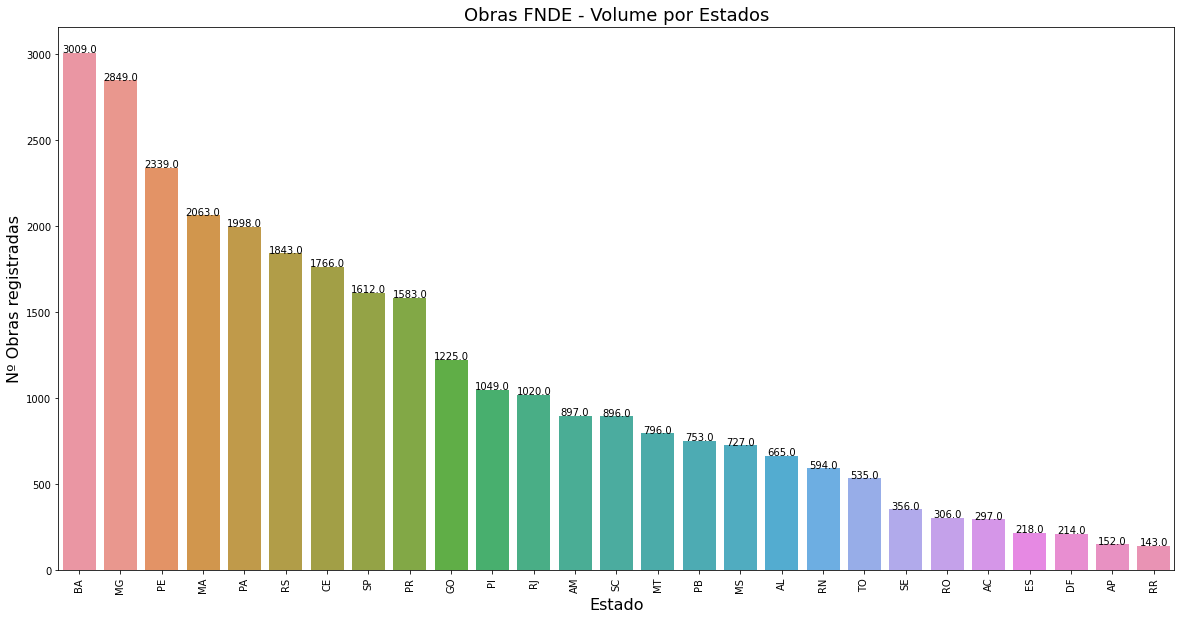

In [ ]:
plt.figure(figsize=(20,10))

s = sns.barplot(x= df_projeto['UF'].value_counts().index, y= df_projeto['UF'].value_counts().values)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Estado", fontdict={'fontsize':16})
plt.ylabel("Nº Obras registradas", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Obras FNDE - Volume por Estados', fontdict={'fontsize': 18})

plt.xticks(rotation = 90)

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

In [ ]:
df_projeto['Situação'].value_counts()

Concluída                       16501
Obra Cancelada                   6115
Execução                         2760
Inacabada                        2613
Paralisada                        995
Licitação                         411
Planejamento pelo proponente      326
Contratação                       180
Em Reformulação                    74
Name: Situação, dtype: int64

# Abaixo temos o percentual de todas as situações que as obras registradas, como valores originados do FNDE se encontram

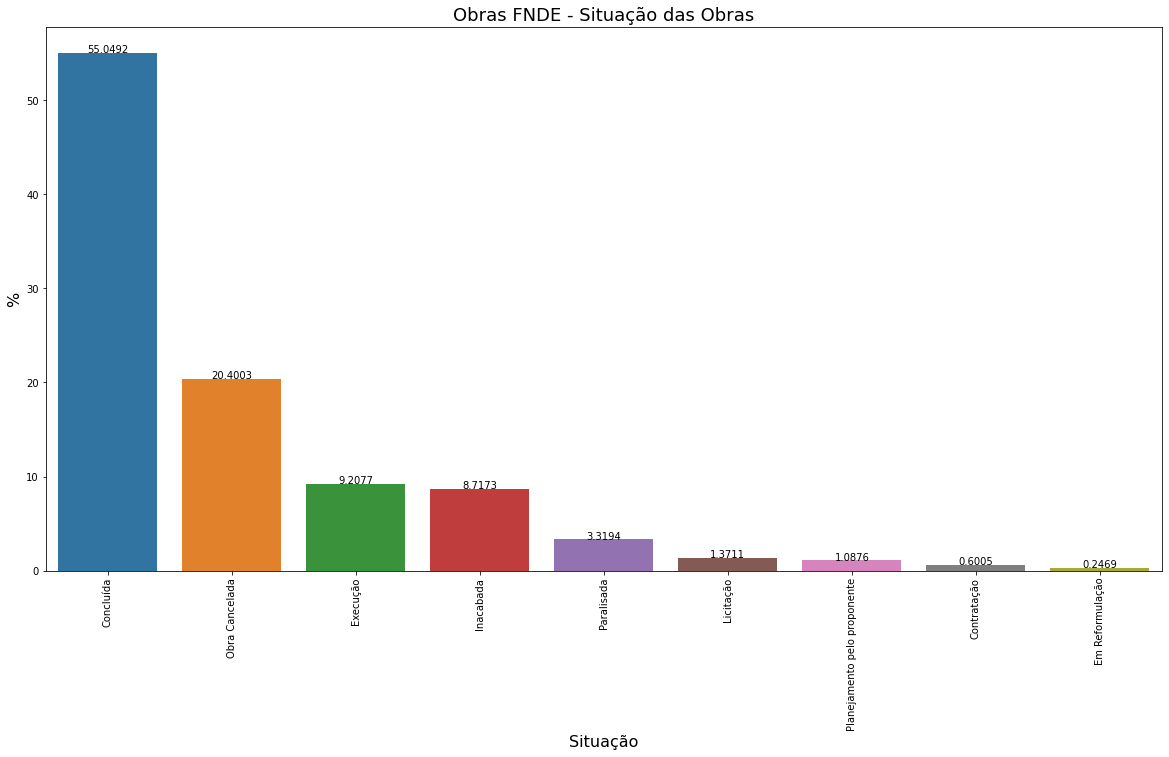

In [ ]:
plt.figure(figsize=(20,10))

s = sns.barplot(x= df_projeto['Situação'].value_counts(). index, y= np.around(100*df_projeto['Situação'].value_counts('p').values,4))

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Situação", fontdict={'fontsize':16})
plt.ylabel("%", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Obras FNDE - Situação das Obras', fontdict={'fontsize': 18})

plt.xticks(rotation = 90)

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# 1) ANALISANDO OBRAS CANCELADAS E PARALISADAS

# Abaixo temos, desse rol de obra, as que foram descontinuados, isso é, considerei como descontinuadas todas as obras que forma canceladas, paralisadas ou inacabadas.

In [ ]:
descontinuadas = df_projeto[(df_projeto['Situação'] == 'Obra Cancelada') | (df_projeto['Situação'] == 'Paralisada')]['Município'].value_counts().head(50)

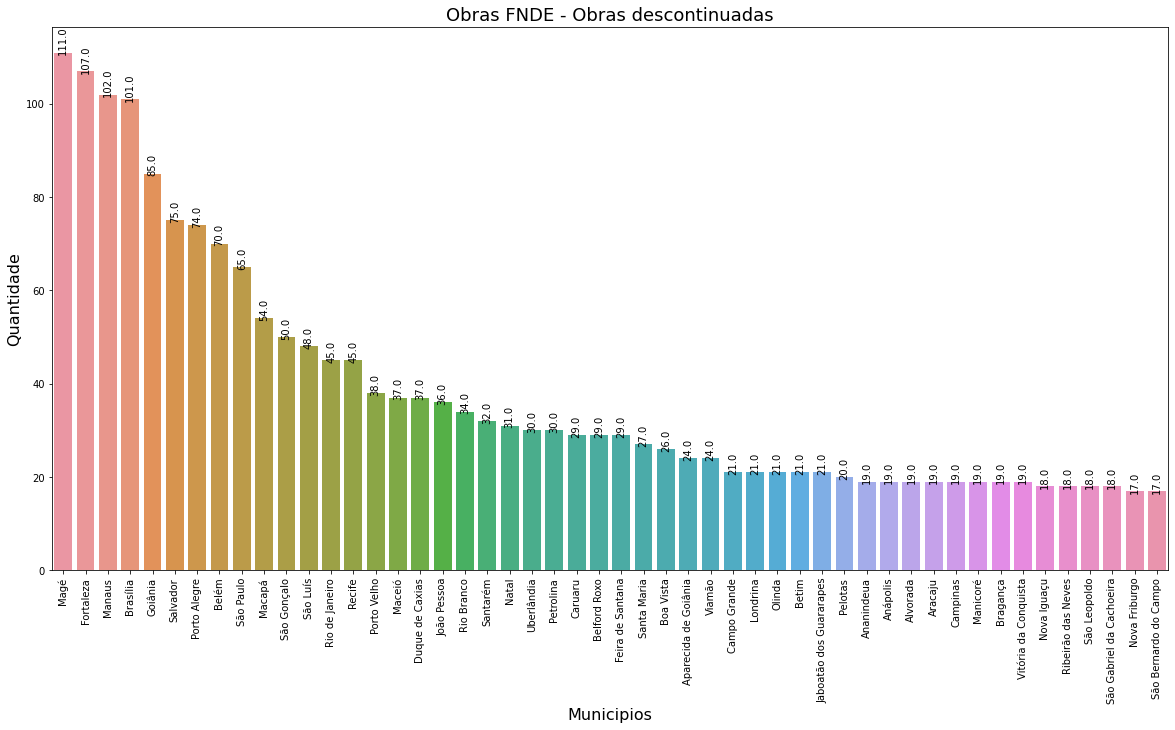

In [ ]:
plt.figure(figsize=(20, 10))
s = sns.barplot(x= descontinuadas.index, y= descontinuadas.values)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Municipios", fontdict={'fontsize':16})
plt.ylabel("Quantidade", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Obras FNDE - Obras descontinuadas', fontdict={'fontsize': 18})

plt.xticks(rotation = 90)

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation= 90)

# Das obras descontinuadas quantas chegaram a ter o termo de convênio firmados com o FNDE?

In [ ]:
descontinuadas_termo_firmado = df_projeto[(df_projeto['Termo/Convênio'].notna()) & ((df_projeto['Situação'] == 'Obra Cancelada') | (df_projeto['Situação'] == 'Paralisada'))]

In [ ]:
descontinuadas_termo_firmado.head()

,ID,Nome,Situação,Município,UF,Mun_UF,Cod_mun,Termo/Convênio,Percentual de Execução,Data Prevista de Conclusão da Obra,Tipo de ensino / Modalidade,Tipo do Projeto,Tipo da Obra,Valor Pactuado pelo FNDE,Modalidade de Licitação,Homologação da Licitação,Data de Assinatura do Contrato,Valor do Contrato,Valor Pactuado com o FNDE,Data da Última Vistoria do Estado ou Município,Situação da Vistoria,OBS,Total Pago,cnpj_empresa_contratada,nom_empresa_contratada
8,1374,700012 - Escola Educação Inf - B Vila Nova - S...,Obra Cancelada,São Luís,MA,São Luís-MA,21113000.0,700012/2008,0.0,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,166178261.0,Tomada de Preço,2012-05-18 00:00:00,2012-05-18,120823393.0,166178261.0,NaT,NaN,NaN,NaN,07370539000181,R K ENGENHARIA E COMERCIO LTDA
11,1377,830054 - Escola de Educação Infantil - Urubure...,Obra Cancelada,Uruburetama,CE,Uruburetama-CE,23138070.0,830054/2007,0.0,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,0.0,NaN,NaN,NaT,0.0,0.0,NaT,NaN,NaN,NaN,NaN,NaN
18,1385,700076 - Escola de Educação Infantil - Humaitá/AM,Obra Cancelada,Humaitá,AM,Humaitá-AM,13017040.0,700076/2008,0.0,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,0.0,NaN,NaN,NaT,0.0,0.0,NaT,NaN,NaN,NaN,NaN,NaN
34,1407,700078 - Escola de Educação Infantil - Encanto/RN,Obra Cancelada,Encanto,RN,Encanto-RN,24033010.0,700078/2008,0.0,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,10.0,NaN,NaN,NaT,0.0,10.0,NaT,NaN,NaN,NaN,NaN,NaN
41,1414,830293 - Escola de Educação Inf - Santa Maria ...,Obra Cancelada,Santa Maria do Salto,MG,Santa Maria do Salto-MG,31581020.0,830293/2007,0.0,NaT,Educação Básica,Escola de Educação Infantil Tipo B,Construção,87996283.0,NaN,NaN,NaT,NaN,87996283.0,NaT,NaN,NaN,NaN,NaN,NaN


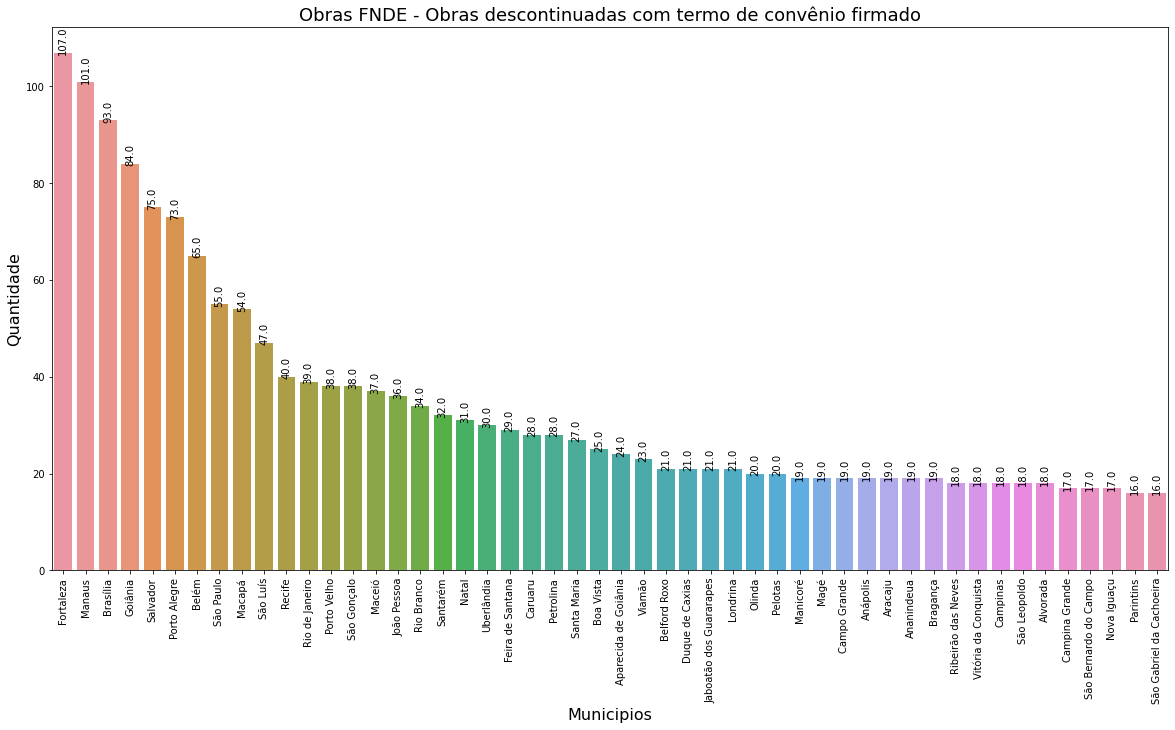

In [ ]:
plt.figure(figsize=(20, 10))
s = sns.barplot(x= descontinuadas_termo_firmado['Município'].value_counts().head(50).index, y= descontinuadas_termo_firmado['Município'].value_counts().head(50).values)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Municipios", fontdict={'fontsize':16})
plt.ylabel("Quantidade", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Obras FNDE - Obras descontinuadas com termo de convênio firmado', fontdict={'fontsize': 18})

plt.xticks(rotation = 90)

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation= 90)

# Das obras descontinuadas e com termos de convênio firmado, quantas efetivamente chegaram a ser sua licitação homologada?

In [ ]:
descontinuadas_homologadas = descontinuadas_termo_firmado[descontinuadas_termo_firmado['Homologação da Licitação'].notna()]

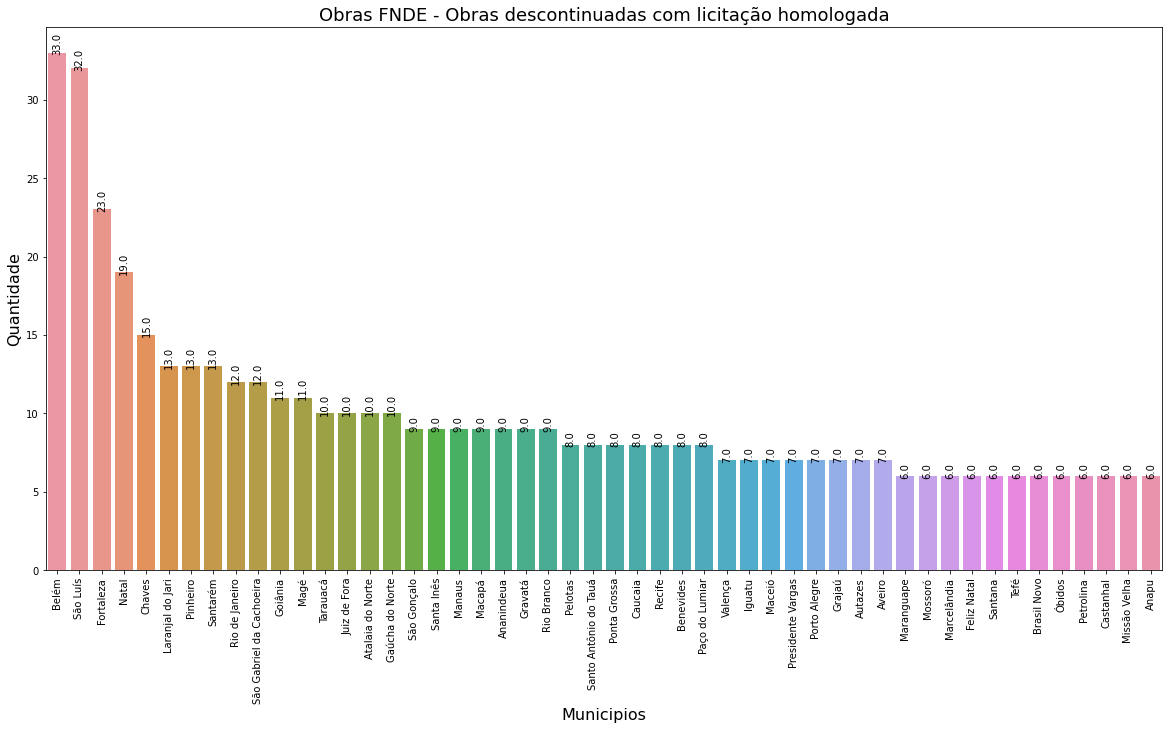

In [ ]:
plt.figure(figsize=(20, 10))
s = sns.barplot(x= descontinuadas_homologadas['Município'].value_counts().head(50).index, y= descontinuadas_homologadas['Município'].value_counts().head(50).values)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Municipios", fontdict={'fontsize':16})
plt.ylabel("Quantidade", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Obras FNDE - Obras descontinuadas com licitação homologada', fontdict={'fontsize': 18})

plt.xticks(rotation = 90)

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation= 90)

# Das obras descontinuadas, com convênios assinados e licitações homologadas, quantas efetivamente tiveram os contratos com o prestador de serviços assinado?

In [ ]:
descontinuadas_ctfirmados = descontinuadas_homologadas[descontinuadas_homologadas['Data de Assinatura do Contrato'].notna()]

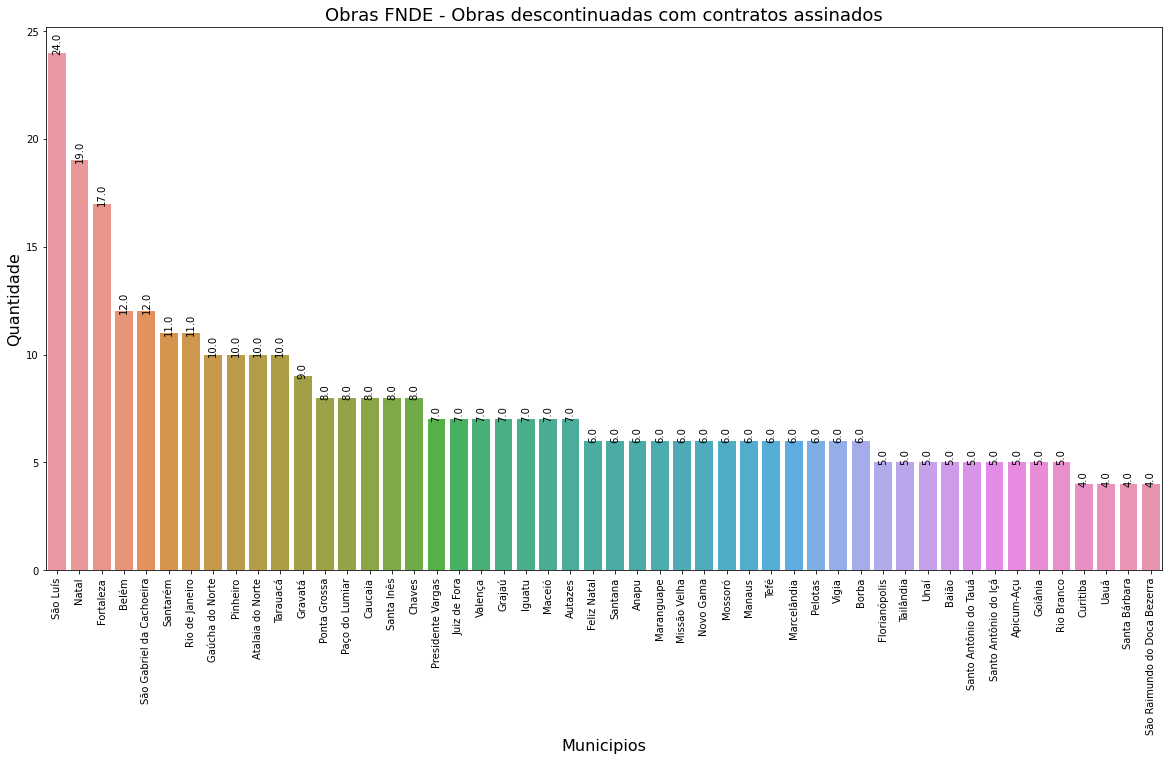

In [ ]:
plt.figure(figsize=(20, 10))
s = sns.barplot(x= descontinuadas_ctfirmados['Município'].value_counts().head(50).index, y= descontinuadas_ctfirmados['Município'].value_counts().head(50).values)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Municipios", fontdict={'fontsize':16})
plt.ylabel("Quantidade", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Obras FNDE - Obras descontinuadas com contratos assinados', fontdict={'fontsize': 18})

plt.xticks(rotation = 90)

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation= 90)

In [ ]:
# conferindo os missing values

np.around((descontinuadas_ctfirmados.isna().sum()/descontinuadas_ctfirmados.shape[0])*100,4)

ID                                                 0.0000
Nome                                               0.0000
Situação                                           0.0000
Município                                          0.0000
UF                                                 0.0000
Mun_UF                                             0.0000
Cod_mun                                            0.0000
Termo/Convênio                                     0.0000
Percentual de Execução                             0.0000
Data Prevista de Conclusão da Obra                25.3538
Tipo de ensino / Modalidade                        0.0000
Tipo do Projeto                                    0.0000
Tipo da Obra                                       1.6615
Valor Pactuado pelo FNDE                           3.2615
Modalidade de Licitação                            1.0462
Homologação da Licitação                           0.0000
Data de Assinatura do Contrato                     0.0000
Valor do Contr

# Obras descontinuadas com 0% de execução registrada

In [ ]:
descontinuadas_ctfirmados_nao_iniciadas = descontinuadas_ctfirmados[descontinuadas_ctfirmados['Percentual de Execução'] == 0]

In [ ]:
descontinuadas_ctfirmados_nao_iniciadas.shape

(513, 25)

In [ ]:
#conferindo os missing values nos 502 registros

np.around((descontinuadas_ctfirmados_nao_iniciadas.isna().sum()/descontinuadas_ctfirmados_nao_iniciadas.shape[0])*100,4)

ID                                                 0.0000
Nome                                               0.0000
Situação                                           0.0000
Município                                          0.0000
UF                                                 0.0000
Mun_UF                                             0.0000
Cod_mun                                            0.0000
Termo/Convênio                                     0.0000
Percentual de Execução                             0.0000
Data Prevista de Conclusão da Obra                77.7778
Tipo de ensino / Modalidade                        0.0000
Tipo do Projeto                                    0.0000
Tipo da Obra                                       0.7797
Valor Pactuado pelo FNDE                           7.2125
Modalidade de Licitação                            1.3645
Homologação da Licitação                           0.0000
Data de Assinatura do Contrato                     0.0000
Valor do Contr

- 2.98% dessas obras não tivere sequer valor de contrato registradas
- 30.27% dessas obras apenar de não terem tido a execução iniciada tiveram valores pagos para as empresas contratadas. Considerei o percentual de execução zerado como uma informação confiável, pois para que haja transferência de recursos do FNDE obrigatoriamente precisa haver um percentual de execução da obra informada no sistema, bem como uma vistoria registrada, com ART do engenheiro responsável pela vistoria. Com exceção dos primeiros 5% que são recebidos já no início do contrato firmado.
- 94.02% dessas obras não tem qualquer observação explicando o motivo da paralização.

In [ ]:
descontinuadas_ctfirmados_nao_iniciadas[descontinuadas_ctfirmados_nao_iniciadas['Total Pago'].notna()].groupby('Situação')['Total Pago'].sum()

Situação
Obra Cancelada    73194316.91
Paralisada         2948894.82
Name: Total Pago, dtype: float64

In [ ]:
descontinuadas_ctfirmados_nao_iniciadas[descontinuadas_ctfirmados_nao_iniciadas['Total Pago'].notna()].groupby('Situação')['Total Pago'].sum().sum()

76143211.72999999

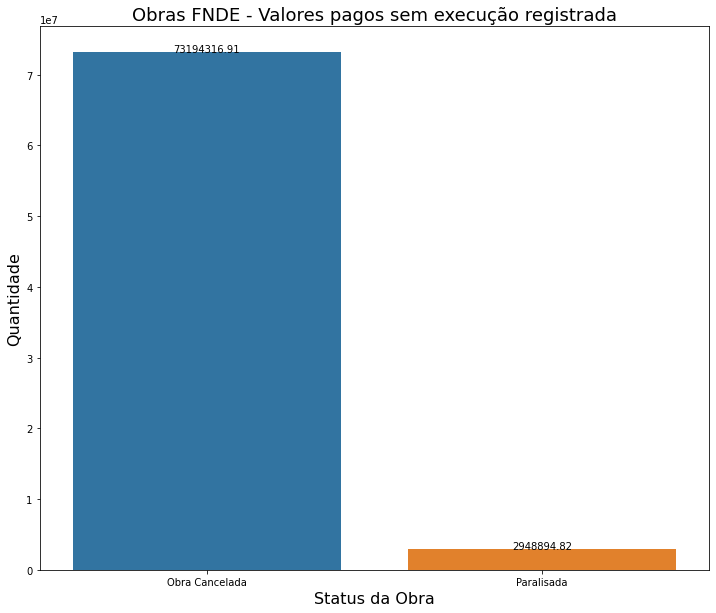

In [ ]:
plt.figure(figsize=(12, 10))
s = sns.barplot(x= descontinuadas_ctfirmados_nao_iniciadas[descontinuadas_ctfirmados_nao_iniciadas['Total Pago'].notna()].groupby('Situação')['Total Pago'].sum().index, y= np.around(descontinuadas_ctfirmados_nao_iniciadas[descontinuadas_ctfirmados_nao_iniciadas['Total Pago'].notna()].groupby('Situação')['Total Pago'].sum().values,2))

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Status da Obra", fontdict={'fontsize':16})
plt.ylabel("Quantidade", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Obras FNDE - Valores pagos sem execução registrada', fontdict={'fontsize': 18})

#plt.xticks(rotation = 90)

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')



```
# Isto` está formatado como código`
```

# 76.654.436,02 milhões de reais foram gastos em obras que não tiveram nenhuma execução apontada nos registros do SIMEC

# Para onde esses valores foram?

In [ ]:
descontinuadas_ctfirmados_nao_iniciadas[descontinuadas_ctfirmados_nao_iniciadas['Total Pago'].notna()]['Município'].value_counts()

Fortaleza           12
Atalaia do Norte    10
Rio de Janeiro      10
Caucaia              8
Ponta Grossa         5
                    ..
Passos               1
Passo Fundo          1
Montes Claros        1
Espinosa             1
Sanharó              1
Name: Município, Length: 232, dtype: int64

In [ ]:
descontinuadas_ctfirmados_nao_iniciadas[descontinuadas_ctfirmados_nao_iniciadas['Total Pago'].notna()].groupby('Município')['Total Pago'].sum().sort_values(ascending=False)

Município
Rio de Janeiro         4002171.77
Fortaleza              3962574.15
Ponta Grossa           2982541.30
Caucaia                2352547.25
Olivença               1740875.12
                          ...    
Lavras do Sul            28561.17
Jaru                     27228.21
Itapajé                  27104.08
Riachão do Jacuípe       26520.25
Ouro Verde de Minas      12217.73
Name: Total Pago, Length: 232, dtype: float64

# Obras descontinuadas com execução iniciada

In [ ]:
descontinuadas_ctfirmados_iniciadas = descontinuadas_ctfirmados[descontinuadas_ctfirmados['Percentual de Execução'] != 0]

In [ ]:
descontinuadas_ctfirmados_iniciadas.shape

(1112, 25)

In [ ]:
#conferindo os missing values nos 1182 registros

np.around((descontinuadas_ctfirmados_iniciadas.isna().sum()/descontinuadas_ctfirmados_iniciadas.shape[0])*100,4)

ID                                                 0.0000
Nome                                               0.0000
Situação                                           0.0000
Município                                          0.0000
UF                                                 0.0000
Mun_UF                                             0.0000
Cod_mun                                            0.0000
Termo/Convênio                                     0.0000
Percentual de Execução                             0.0000
Data Prevista de Conclusão da Obra                 1.1691
Tipo de ensino / Modalidade                        0.0000
Tipo do Projeto                                    0.0000
Tipo da Obra                                       2.0683
Valor Pactuado pelo FNDE                           1.4388
Modalidade de Licitação                            0.8993
Homologação da Licitação                           0.0000
Data de Assinatura do Contrato                     0.0000
Valor do Contr

In [ ]:
descontinuadas_ctfirmados_iniciadas[descontinuadas_ctfirmados_iniciadas['Total Pago'].notna()].head()

,ID,Nome,Situação,Município,UF,Mun_UF,Cod_mun,Termo/Convênio,Percentual de Execução,Data Prevista de Conclusão da Obra,Tipo de ensino / Modalidade,Tipo do Projeto,Tipo da Obra,Valor Pactuado pelo FNDE,Modalidade de Licitação,Homologação da Licitação,Data de Assinatura do Contrato,Valor do Contrato,Valor Pactuado com o FNDE,Data da Última Vistoria do Estado ou Município,Situação da Vistoria,OBS,Total Pago,cnpj_empresa_contratada,nom_empresa_contratada
6376,18061,Sem nome,Obra Cancelada,Jequiá da Praia,AL,Jequiá da Praia-AL,27037590.0,249/2011,3.21,2013-06-30,Educação Básica,Escola de Educação Infantil Tipo B,Construção,12196466.0,NaN,2011-11-18 00:00:00,2011-11-23,119841945.0,12196466.0,2014-08-26,Paralisado,Contrato Rescindido,609823.30,11085571000192,J M F PROJETOS E CONSTRUCOES LTDA
6386,18071,QUADRA COBERTA EM ESCOLA,Paralisada,Colniza,MT,Colniza-MT,51032540.0,1510/2011,96.86,2023-05-03,Educação Básica,Quadra Escolar Coberta com Palco,Construção,4900000.0,Concorrência,2016-06-15 00:00:00,2016-06-17,59678343.0,4900000.0,2022-06-07,Paralisado,Paralisação por falta de pagamento à empresa e...,294000.00,01379965000108,POLI ENGENHARIA E COMERCIO LTDA
6559,18245,EMEF SANTA IRENE,Paralisada,Pelotas,RS,Pelotas-RS,43144070.0,1118/2011,61.48,2021-04-20,Educação Básica,Quadra Escolar Coberta com Palco,Construção,48652699.0,Dispensa,2018-05-17 00:00:00,2018-05-17,52602134.0,48652699.0,2022-04-04,Paralisado,Outros,194610.80,05123912000174,EMPREITEIRA MODELAR LTDA
6608,18294,Creche Jardim Brasil,Obra Cancelada,Suzano,SP,Suzano-SP,35525020.0,1088/2011,1.01,2015-08-11,Educação Básica,Escola de Educação Infantil Tipo C,Construção,61999294.0,Concorrência,2012-09-05 00:00:00,2012-12-26,128930668.0,61999294.0,2016-11-23,Paralisado,Contrato Rescindido,185997.87,54547633000143,FL - EXATA COMERCIAL E CONSTRUTORA LTDA
6633,18319,Prefeitura Municipal de Candeias,Obra Cancelada,Candeias,BA,Candeias-BA,29065010.0,320/2011,47.17,2015-11-08,Educação Básica,Escola de Educação Infantil Tipo B,Construção,132991511.0,Tomada de Preço,2014-04-02 00:00:00,2014-04-04,109131176.0,132991511.0,2016-06-13,Paralisado,Questões Climáticas,997436.33,16479763000105,ZQUADRO BLOCO ESTRUTURAL LTDA - EPP


In [ ]:
descontinuadas_ctfirmados_iniciadas[descontinuadas_ctfirmados_iniciadas['Total Pago'].notna()].groupby('Situação')['Total Pago'].sum()

Situação
Obra Cancelada    2.904343e+07
Paralisada        4.662403e+08
Name: Total Pago, dtype: float64

In [ ]:
descontinuadas_ctfirmados_iniciadas[descontinuadas_ctfirmados_iniciadas['Total Pago'].notna()].groupby('Situação')['Total Pago'].sum().sum()

495283704.67

# Verba pública desperdição com obras canceladas ou paralisadas.

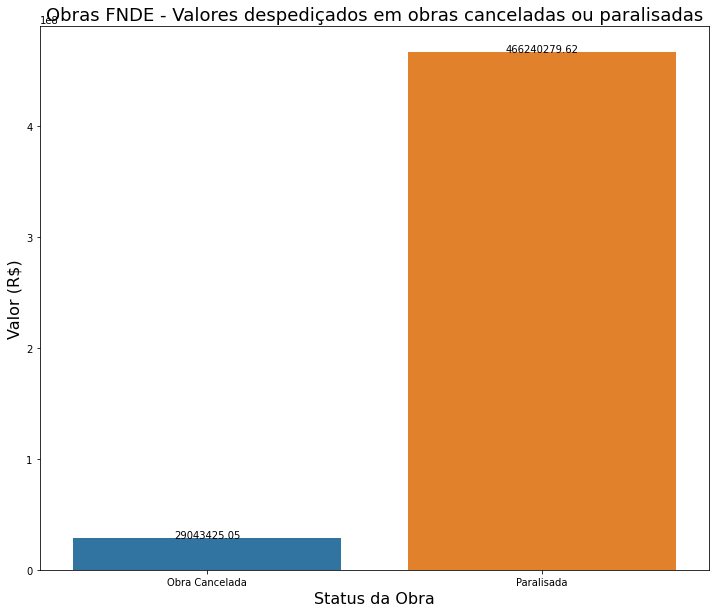

In [ ]:
plt.figure(figsize=(12, 10))
s = sns.barplot(x= descontinuadas_ctfirmados_iniciadas[descontinuadas_ctfirmados_iniciadas['Total Pago'].notna()].groupby('Situação')['Total Pago'].sum().index, y= np.around(descontinuadas_ctfirmados_iniciadas[descontinuadas_ctfirmados_iniciadas['Total Pago'].notna()].groupby('Situação')['Total Pago'].sum().values,2))

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Status da Obra", fontdict={'fontsize':16})
plt.ylabel("Valor (R$)", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Obras FNDE - Valores despediçados em obras canceladas ou paralisadas', fontdict={'fontsize': 18})

#plt.xticks(rotation = 90)

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Temos o total de 519.007.809,37 milhões de reais investidos em obras que foram canceladas ou paralisadas por algum motivo.

In [ ]:
descontinuadas_ctfirmados_iniciadas[descontinuadas_ctfirmados_iniciadas['Total Pago'].notna()].describe().T

,count,mean,std,min,25%,50%,75%,max
ID,967.0,7.148919e+05,4.582672e+05,18061.00,3.110300e+04,1006838.00,1.014585e+06,1.109057e+06
Cod_mun,967.0,2.689122e+07,1.089639e+07,11000310.00,2.101252e+07,24111060.00,3.142754e+07,5.221858e+07
Percentual de Execução,967.0,5.162384e+01,2.824556e+01,0.01,2.945500e+01,53.88,7.425000e+01,1.000000e+02
Valor Pactuado pelo FNDE,967.0,9.956195e+07,1.042959e+08,0.00,2.234047e+07,50999998.00,1.325596e+08,1.187836e+09
Valor do Contrato,967.0,1.013826e+08,1.238702e+08,706007.00,2.355073e+07,62964664.00,1.290559e+08,1.281435e+09
Valor Pactuado com o FNDE,967.0,9.956195e+07,1.042959e+08,0.00,2.234047e+07,50999998.00,1.325596e+08,1.187836e+09
Total Pago,967.0,5.121858e+05,6.310650e+05,637.09,1.373290e+05,337201.66,6.498902e+05,5.915367e+06


In [ ]:
descontinuadas_ctfirmados_iniciadas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112 entries, 128 to 29694
Data columns (total 25 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   ID                                              1112 non-null   int64         
 1   Nome                                            1112 non-null   object        
 2   Situação                                        1112 non-null   object        
 3   Município                                       1112 non-null   object        
 4   UF                                              1112 non-null   object        
 5   Mun_UF                                          1112 non-null   object        
 6   Cod_mun                                         1112 non-null   float64       
 7   Termo/Convênio                                  1112 non-null   object        
 8   Percentual de Execução                       

In [ ]:
# convertendo coluna object para o tipo data, para em seguida arrancar apenas o ano.
descontinuadas_ctfirmados_iniciadas['Ano de homologação'] = descontinuadas_ctfirmados_iniciadas['Homologação da Licitação'].astype('datetime64').dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
descontinuadas_ctfirmados_iniciadas['Município'].value_counts().head(50)

São Luís                        19
Natal                           19
Pinheiro                         9
Tarauacá                         9
Paço do Lumiar                   8
Chaves                           8
Belém                            8
Gravatá                          7
Presidente Vargas                7
Grajaú                           7
Iguatu                           7
Santarém                         7
Borba                            6
Manaus                           6
Autazes                          6
Anapu                            6
Missão Velha                     6
Vigia                            6
Unaí                             5
Fortaleza                        5
Apicum-Açu                       5
Goiânia                          5
Santo Antônio do Içá             5
Baião                            5
Eunápolis                        4
Maceió                           4
Oeiras do Pará                   4
Salgueiro                        4
Melgaço             

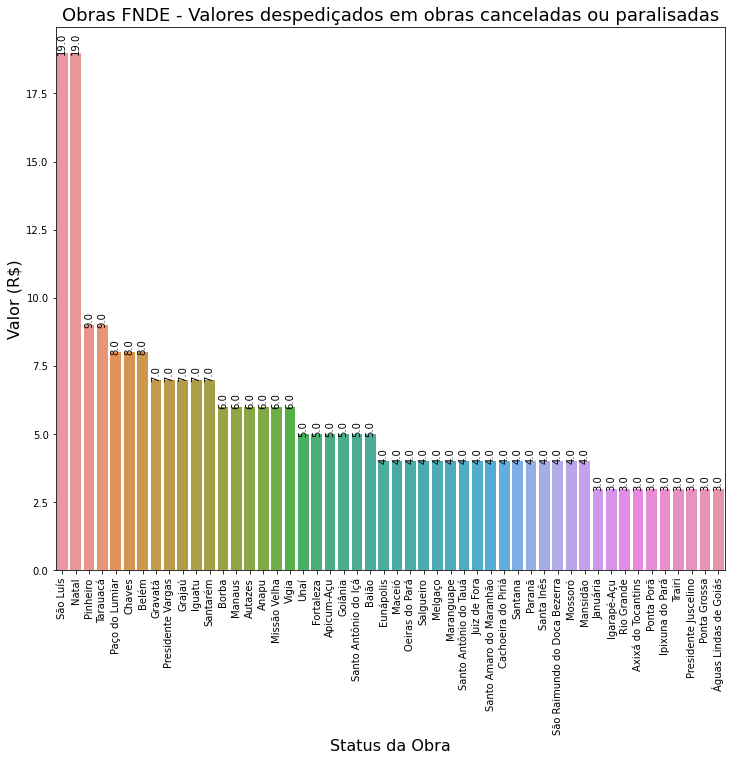

In [ ]:
plt.figure(figsize=(12, 10))
s = sns.barplot(x= descontinuadas_ctfirmados_iniciadas['Município'].value_counts().head(50).index, y= descontinuadas_ctfirmados_iniciadas['Município'].value_counts().head(50).values)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Status da Obra", fontdict={'fontsize':16})
plt.ylabel("Valor (R$)", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Obras FNDE - Valores despediçados em obras canceladas ou paralisadas', fontdict={'fontsize': 18})

plt.xticks(rotation = 90)

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation=90)

In [ ]:
np.around(descontinuadas_ctfirmados_iniciadas['UF'].value_counts('p')*100,2)

PA    12.95
MG    12.59
MA    12.59
BA     9.17
GO     7.01
CE     5.94
AM     4.41
RN     4.23
PR     4.14
PE     3.60
RS     3.06
PI     2.79
PB     2.16
SP     2.16
MT     1.89
TO     1.80
AL     1.71
AC     1.44
SC     1.44
RJ     1.17
RO     1.17
MS     0.81
SE     0.72
ES     0.54
AP     0.54
Name: UF, dtype: float64

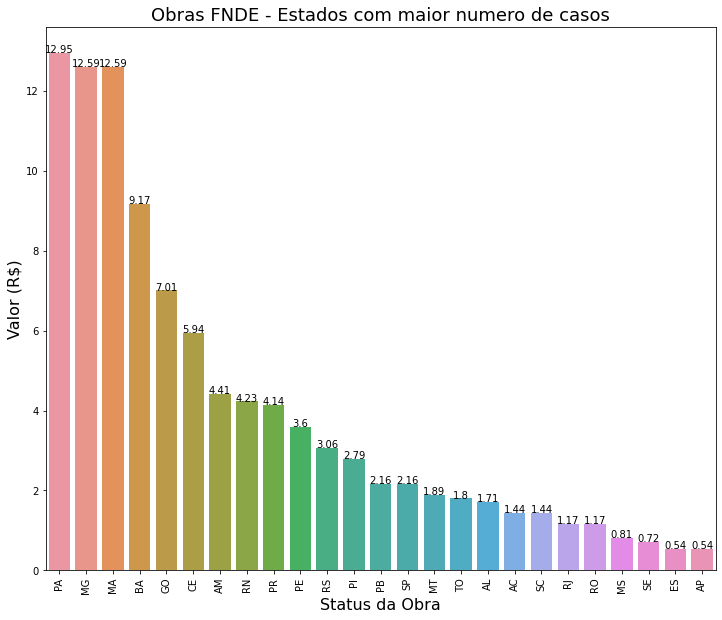

In [ ]:
plt.figure(figsize=(12, 10))
s = sns.barplot(x= np.around(descontinuadas_ctfirmados_iniciadas['UF'].value_counts('p')*100,2).index, y= np.around(descontinuadas_ctfirmados_iniciadas['UF'].value_counts('p')*100,2).values)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Status da Obra", fontdict={'fontsize':16})
plt.ylabel("Valor (R$)", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Obras FNDE - Estados com maior numero de casos', fontdict={'fontsize': 18})

plt.xticks(rotation = 90)

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Quais as empresas que mais aparecem nessas situações?

In [ ]:
descontinuadas_ctfirmados['cnpj_empresa_contratada'].value_counts().head(50)

10720768000193    16
15544385000125    14
02934270000103    10
08850652000127    10
17775260000131    10
03522765000180    10
05821742000100    10
07561334000183     8
07806312000136     8
13017783000168     8
05044246000189     7
69426294000114     6
12593994000186     6
18384447000177     5
27616569000132     5
04436634000142     5
08914052000185     5
17257344000183     5
03832803000109     5
10312341000156     5
04603193000126     5
01832327000192     4
12656434000123     4
04899663000140     4
00484746000118     4
00692228000190     4
05757618000114     4
17712774000148     4
16724567000140     4
16979364000103     4
11519180000139     4
04115756000137     4
00611868000128     4
09053050000101     4
22156631000137     4
00521113000132     4
10220039000178     4
06230666000112     4
07564580000199     4
10671357000155     4
14093288000109     4
03449003000103     4
18768110000163     4
22797932000140     4
21725552000137     4
07451334000120     3
02671087000154     3
0256036100011

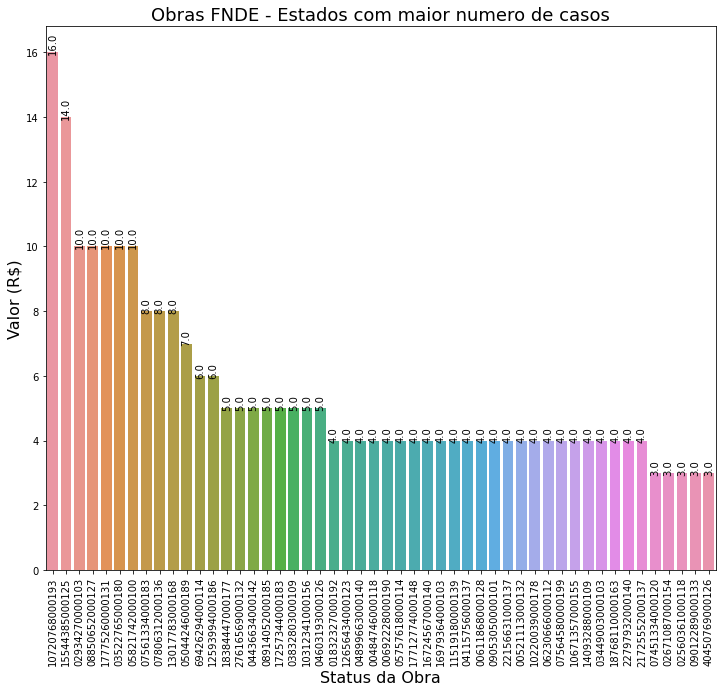

In [ ]:
plt.figure(figsize=(12, 10))
s = sns.barplot(x= descontinuadas_ctfirmados['cnpj_empresa_contratada'].value_counts().head(50).index, y= descontinuadas_ctfirmados['cnpj_empresa_contratada'].value_counts().head(50).values)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Status da Obra", fontdict={'fontsize':16})
plt.ylabel("Valor (R$)", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Obras FNDE - Estados com maior numero de casos', fontdict={'fontsize': 18})

plt.xticks(rotation = 90)

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation=90)

# De quantas obras as empresas que aparecem mais vezes na lista de obras descontinuadas participaram, incluindo todas as obras do FNDE?

In [ ]:
df_projeto[(df_projeto['cnpj_empresa_contratada'] == '(10720768000193) SILVA & BONFIM LTDA ME')]['cnpj_empresa_contratada'].value_counts()

Series([], Name: cnpj_empresa_contratada, dtype: int64)

# Das 24 Obras que a empresa (10720768000193) SILVA & BONFIM LTDA ME foi contrada para executar, 16 delas foram canceladas ou paralisadas.

In [ ]:
df_projeto[df_projeto['cnpj_empresa_contratada'] == '(15544385000125) CAPA CONSTRUCOES, EVENTOS E EMPREENDIMENTOS LTDA - ME']['cnpj_empresa_contratada'].value_counts()


Series([], Name: cnpj_empresa_contratada, dtype: int64)

# Das 32 Obras que a empresa (15544385000125) CAPA CONSTRUCOES, EVENTOS E EMPREENDIMENTOS LTDA - ME foi contrada para executar, 16 delas foram canceladas ou paralisadas.

In [ ]:
descontinuadas_ctfirmados['Tipo do Projeto'].value_counts('p')*100

Quadra Escolar Coberta com Vestiário             18.584615
Creche Pré-Escola - Tipo 1                       11.200000
Creche Pré-Escola - Tipo 2                        9.661538
Escola 6 Salas                                    6.769231
Cobertura de Quadra Escolar Pequena               6.153846
Escola 4 Salas                                    4.307692
Escola 12 Salas                                   4.307692
Escola 2 Salas                                    4.246154
Ampliação                                         4.123077
Quadra Coberta - Projeto Próprio                  4.061538
Escola de Educação Infantil Tipo B                3.938462
Escola - Projeto Próprio                          3.446154
Cobertura de Quadra - Projeto Próprio             2.953846
Cobertura de Quadra Escolar Grande                2.276923
MI - Escola de Educação Infantil Tipo B           2.215385
Escola 1 Sala                                     1.907692
Escola de Ensino Médio Profissionalizante         1.9076

In [ ]:
descontinuadas_ctfirmados.groupby('UF')['cnpj_empresa_contratada'].value_counts()

UF  cnpj_empresa_contratada
AC  01832327000192             4
    02402615000170             3
    00938941000170             2
    09419510000172             2
    02677444000191             1
                              ..
TO  26749913000107             1
    27898589000143             1
    33310406000120             1
    37355534000140             1
    38136123000127             1
Name: cnpj_empresa_contratada, Length: 1079, dtype: int64

In [ ]:
obras_concluidas_inacabadas = df_projeto[(df_projeto['Situação da Vistoria'] == 'Concluído') & (df_projeto['Percentual de Execução'] != 100)]

In [ ]:
obras_concluidas_inacabadas[obras_concluidas_inacabadas['Percentual de Execução'] < 90]

,ID,Nome,Situação,Município,UF,Mun_UF,Cod_mun,Termo/Convênio,Percentual de Execução,Data Prevista de Conclusão da Obra,Tipo de ensino / Modalidade,Tipo do Projeto,Tipo da Obra,Valor Pactuado pelo FNDE,Modalidade de Licitação,Homologação da Licitação,Data de Assinatura do Contrato,Valor do Contrato,Valor Pactuado com o FNDE,Data da Última Vistoria do Estado ou Município,Situação da Vistoria,OBS,Total Pago,cnpj_empresa_contratada,nom_empresa_contratada
42,1415,700021 - Escola de Educação Infantil - Jandaír...,Concluída,Jandaíra,RN,Jandaíra-RN,24051080.0,700021/2008,83.35,2022-04-25,Educação Básica,Escola de Educação Infantil Tipo B,Construção,94592143.0,Tomada de Preço,2008-07-23 00:00:00,2008-10-16,94592143.0,94592143.0,2021-07-29,Concluído,NaN,NaN,08073857000143,LIBERTY FOMENTO E EMPREENDIMENTOS LTDA
59,1432,830103 -Escola de Educação Infantil - Formoso ...,Inacabada,Formoso do Araguaia,TO,Formoso do Araguaia-TO,17082050.0,830103/2007,89.31,2016-11-30,Educação Básica,Escola de Educação Infantil Tipo B,Construção,111999147.0,Tomada de Preço,2009-01-15 00:00:00,2009-01-19,111999147.0,111999147.0,2015-11-23,Concluído,NaN,NaN,07617512000140,CONSTRUTORA SAO MIGUEL LTDA - ME
155,1541,830164 - Escola de Educação Inf - Conceição do...,Concluída,Conceição do Rio Verde,MG,Conceição do Rio Verde-MG,31177020.0,830164/2007,80.27,2017-12-30,Educação Básica,Escola de Educação Infantil Tipo B,Construção,9500000.0,Tomada de Preço,NaN,2009-06-29,97979005.0,9500000.0,2017-11-28,Concluído,NaN,NaN,02040923000100,CONSTRUTORA PENHA E PIMENTEL LTDA
310,1728,700051 - Escola de Educação Infantil - Teotôni...,Concluída,Teotônio Vilela,AL,Teotônio Vilela-AL,27091520.0,700051/2008,80.00,2018-06-30,Educação Básica,Escola de Educação Infantil Tipo B,Construção,70707071.0,Tomada de Preço,2009-10-22 00:00:00,2009-10-28,117901895.0,70707071.0,2017-11-10,Concluído,NaN,NaN,06181737000134,COTRIM ENGENHARIA LTDA
687,2166,830049 - Escola de Educação Infantil - Horizon...,Concluída,Horizonte,CE,Horizonte-CE,23052330.0,830049/2007,88.95,2009-12-28,Educação Básica,Escola de Educação Infantil Tipo B,Construção,9500000.0,Tomada de Preço,2008-06-24 00:00:00,2008-06-24,102608851.0,9500000.0,2018-02-09,Concluído,NaN,NaN,07149996000140,AR CONSTRUCOES LTDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28480,1070454,ESCOLA MUNICIPALSERGIO LUIS PESSOA BRAGA - Mac...,Concluída,Maceió,AL,Maceió-AL,27043020.0,104032/2017,87.40,2019-02-14,Educação Básica,Reforma,Reforma,6949365.0,Dispensa,2017-09-04 00:00:00,2017-09-12,4843707.0,6949365.0,2019-02-18,Concluído,NaN,59764.54,14554855000179,UNICA ENGENHARIA E EMPREENDIMENTOS IMOBILIARIO...
28481,1070455,ESCOLA MUNICIPAL SUZEL DANTAS - Maceió - AL,Concluída,Maceió,AL,Maceió-AL,27043020.0,104033/2017,80.67,2017-11-13,Educação Básica,Reforma,Reforma,4147454.0,Dispensa,2017-09-04 00:00:00,2017-09-12,2961282.0,4147454.0,2018-06-28,Concluído,NaN,33179.63,14554855000179,UNICA ENGENHARIA E EMPREENDIMENTOS IMOBILIARIO...
28495,1070572,ESCOLA ADELINA PONTUAL FERREIRA - Amaraji - PE,Concluída,Amaraji,PE,Amaraji-PE,26009060.0,104168/2017,83.19,2019-03-27,Educação Básica,Reforma,Reforma,6678789.0,Convite,2017-10-26 00:00:00,2017-10-30,6463955.0,6678789.0,2019-03-27,Concluído,NaN,55433.94,02173244000100,BRASILAR COMERCIO E SERVICOS DE ENGENHARIA LTDA
28522,1072443,CRECHE MUNICIPAL IRACI PINTO DE BARROS - Quipa...,Concluída,Quipapá,PE,Quipapá-PE,26115070.0,106792/2017,0.00,2020-12-25,Educação Básica,Reforma,Reforma,32323514.0,Tomada de Preço,2018-06-25 00:00:00,2018-06-25,3073458.0,32323514.0,2020-12-23,Concluído,NaN,323235.14,12070635000144,CP CONSTRUCOES LTDA - EPP


# 2) Analisando as Obras Inacabadas

# 3) Analisando as Obras Concluidas

## Variável target

- Concluída
- Não concluída

- pegar os dados no Mec das escolas que estão em funcionamento (lower as strings e concatenar com o estado e municipio ou cep)
- pegar os dados de alunos existentes e cruzar com a quantidade de vagas para verificar a necessidade.

## Próximos passos:  
- Incluir os CNPJs faltantes;  
- Verificar se há NA decorrente do merge com infos dos municípios;  
- Criar colunas calculadas fazendo um group_by por empresas;  
- Data cleaning;  
- Rodar clusterização para analisar os agrupamentos sugeridos e tendências dos dados; 
- Análise exploratória com base nas saídas da clusterização; 
- Transformação de variáveis - categóricas para numéricas;  
- Modelagem


- 